In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
NFFT = 4096
x = np.fromfile('data/QO-100_WB_2023-03-12T10_44_51_spectrum', 'float32').reshape(-1, NFFT)
t = np.fromfile('data/QO-100_WB_2023-03-12T10_44_51_timestamps', 'datetime64[ns]')[:x.shape[0]]

In [3]:
fs = 20e6
f_center = 745 + 9750
faxis = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/fs))*1e-6 + f_center

In [4]:
bandpass_offset = 10**(56/10)
bandpass = bandpass_offset * np.polyval(
    np.load('bandpass_polynomial_calibration.npy'),
    np.fft.fftshift(np.fft.fftfreq(NFFT)))
bandpass_inv = (1 / bandpass).astype('float32')

In [5]:
x_flat = x * bandpass_inv

In [6]:
rx_noise_sel = (faxis <= 10489) | ((faxis >= 10500.5) & (np.abs(faxis - 10503.02) >= 0.03))

Text(0, 0.5, 'PSD (dB)')

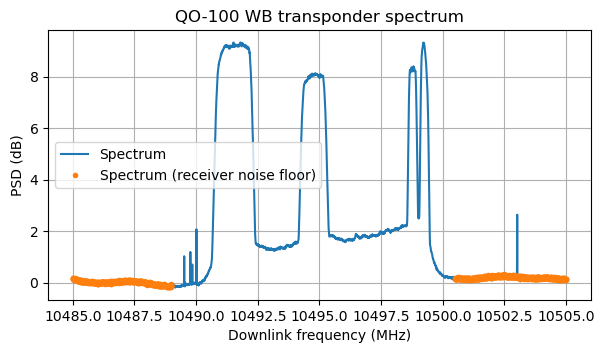

In [7]:
plt.plot(faxis, 10*np.log10(x_flat[0]))
plt.plot(faxis[rx_noise_sel], 10*np.log10(x_flat[0][rx_noise_sel]), '.')
plt.grid()
plt.legend(['Spectrum', 'Spectrum (receiver noise floor)'])
plt.title('QO-100 WB transponder spectrum')
plt.xlabel('Downlink frequency (MHz)')
plt.ylabel('PSD (dB)')

In [8]:
rx_noise = np.average(x_flat[:, rx_noise_sel], axis=1)

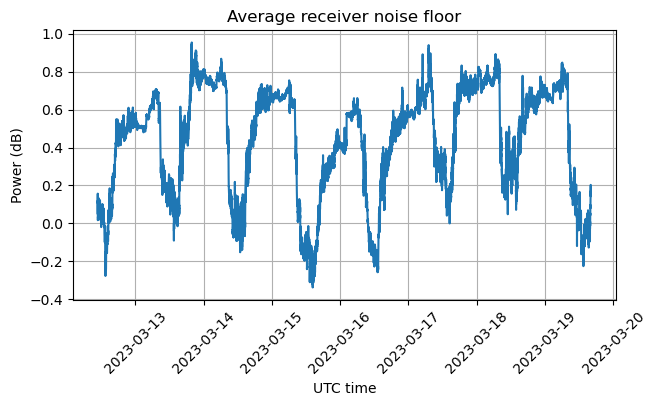

In [9]:
plt.plot(t, 10*np.log10(rx_noise))
plt.grid()
plt.title('Average receiver noise floor')
plt.xlabel('UTC time')
plt.ylabel('Power (dB)')
plt.xticks(rotation=45);

In [10]:
x_cal = x_flat / rx_noise[:, np.newaxis]

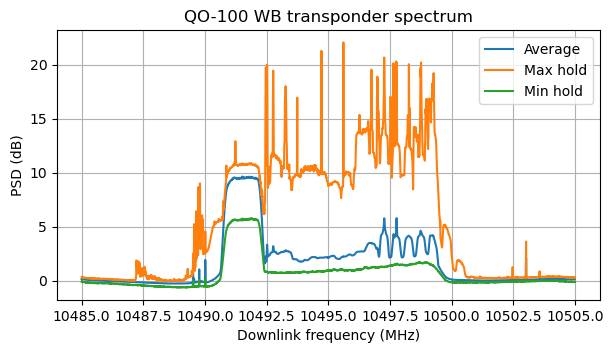

In [11]:
plt.plot(faxis, 10*np.log10(np.average(x_cal, axis=0)), label='Average')
plt.plot(faxis, 10*np.log10(np.max(x_cal, axis=0)), label='Max hold')
plt.plot(faxis, 10*np.log10(np.min(x_cal, axis=0)), label='Min hold')
plt.grid()
plt.legend()
plt.title('QO-100 WB transponder spectrum')
plt.xlabel('Downlink frequency (MHz)')
plt.ylabel('PSD (dB)');

In [12]:
x_dB = 10*np.log10(x_cal)
line_avg = round(x_dB.shape[0] / 2048)
end = x_dB.shape[0] // line_avg * line_avg
x_dB = np.average(x_dB[:end].reshape(-1, line_avg, x_dB.shape[1]),
                  axis=1)

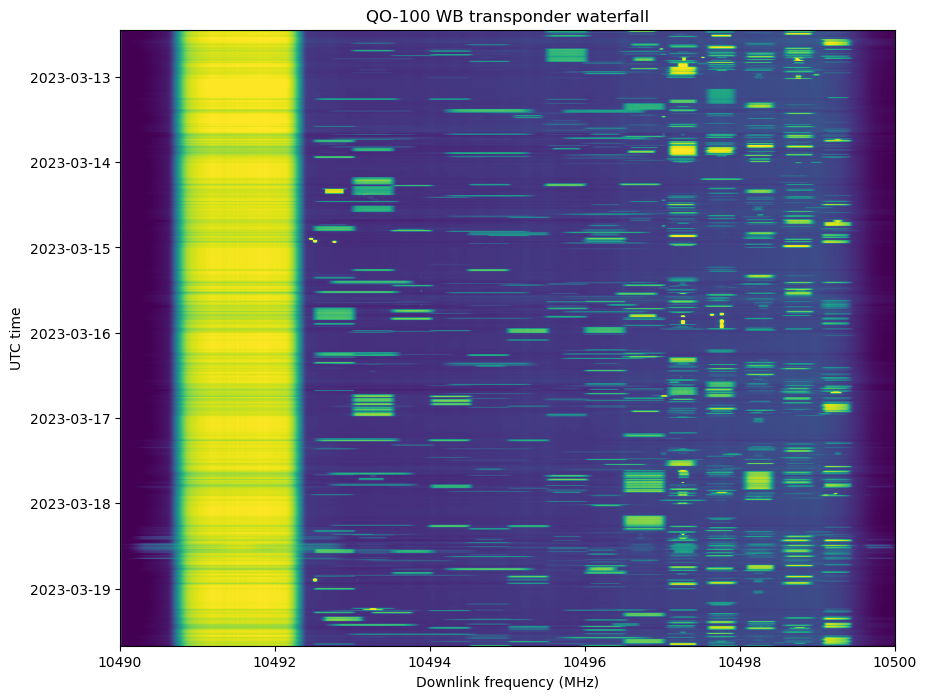

In [13]:
fsel = (faxis >= 10490) & (faxis <= 10500)
plt.figure(figsize=(10, 8))
plt.imshow(x_dB[:, fsel], aspect='auto', vmin=0, vmax=10,
           extent=[faxis[fsel][0], faxis[fsel][-1],
                   mdates.date2num(t[end-1]), mdates.date2num(t[0])])
plt.gca().yaxis_date()
plt.gca().ticklabel_format(axis='x', useOffset=False)
plt.xlabel('Downlink frequency (MHz)')
plt.ylabel('UTC time')
plt.title('QO-100 WB transponder waterfall');